# Tabular data augmentation with score-based generative models 

The selected dataset is the well-known german credit [dataset](https://github.com/Giskard-AI/giskard-client/blob/main/sample_data/classification/credit/german_credit_prepared.csv) which contains data related to bank customers' attributes as well as a variable indicating whether they defaulted on their credit. This dataset is usually used in classification models in order to build credit scoring models. 

However, the small amount of entries and the imbalanced class issue can make it difficult to build a scorer which correctly detects default credits. One solution to this problem is to synthetically generate data to increase the number of default credits. For this purpose we use **score-based generative modeling with multiple noise perturbations**. The main idea is to represent a distribution by modeling its score function, which can be estimated by training a score-based model of free-form architectures with score matching.

It consists in two steps: 

1. Learn score functions using **gradients of log probability density functions** on a large number of noise-perturbed data distributions
2. Generate samples with **Langevin-type sampling**

## Setup

In [460]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [581]:
import pandas as pd
import numpy as np 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [554]:
from src.utils import (
    load_config, 
    load_pickle, 
    get_clf_metrics, 
    display_clf_metrics
)
from src.data import Data
from src.runner.scorenet_runner import ScoreNetRunner
from src.runner.anneal_runner import AnnealRunner

## Load original data

In [435]:
df = pd.read_csv("datasets/credit_data.csv")

print(df.info())
df.default.value_counts(normalize=True, dropna=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   default                     1000 non-null   object
 1   account_check_status        1000 non-null   object
 2   duration_in_month           1000 non-null   int64 
 3   credit_history              1000 non-null   object
 4   purpose                     1000 non-null   object
 5   credit_amount               1000 non-null   int64 
 6   savings                     1000 non-null   object
 7   present_employment_since    1000 non-null   object
 8   installment_as_income_perc  1000 non-null   int64 
 9   sex                         1000 non-null   object
 10  personal_status             1000 non-null   object
 11  other_debtors               1000 non-null   object
 12  present_residence_since     1000 non-null   int64 
 13  property                    1000 non-null   objec

Not default    0.7
Default        0.3
Name: default, dtype: float64

Entries which have defaulted on their credit only account for 30% of the entire dataset. We thus focus the generative process on these samples. 

## Data preparation

In [590]:
CFG_TYPE = "anneal"                           # "scorenet" or "anneal"
cfg = load_config(f"configs/{CFG_TYPE}.yaml") 

In [591]:
data = Data(cfg["data"])
print(data) 

data.preprocess(df)
data.make_loaders()

Data(target=default, classification=True, reference=Default, test_prop=0.2, batch_size=32)


## Train generator

The loss function used to train the score-based generator depends on the `algo` argument entered in [`config`](configs/): 

- `dsm` means we use the denoising score matching objective as loss function
- `ssm` means we use sliced score matching objective to greatly scale up the computation of score matching. 

One can also choose to add multiple noise perturbations with the [`anneal`](configs/anneal.yaml) configuration.

More details can be found [here](https://yang-song.net/blog/2019/ssm/). 

In [578]:
if CFG_TYPE == "scorenet":
    runner = ScoreNetRunner(cfg, data)

elif CFG_TYPE == "anneal":
    runner = AnnealRunner(cfg, data) 

if cfg["mode"] == "train":
    loss_tracker = runner.train()

elif cfg["mode"] == "test":
    loss_tracker = load_pickle(f"{cfg['backup']['dir']}/loss.pkl")

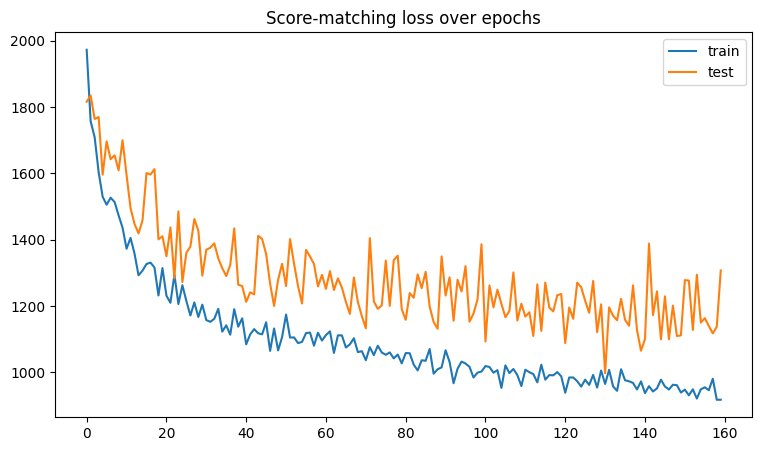

In [579]:
pd.DataFrame(loss_tracker).plot(figsize=(9, 5), title="Score-matching loss over epochs"); 

## Generate new samples

Once the score-based model trained, we can use an iterative procedure called Langevin dynamics to draw samples from it. Langevin dynamics provides an MCMC procedure to sample from a distribution using only its score function.

In [580]:
synthetic_samples = runner.sample()
synthetic_samples.shape

Generating 3 batches with 32 samples each using Langevin dynamics.:   0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([96, 48])

In [582]:
data.generate(synthetic_samples)

In [583]:
data.synthetic_df.head()

,duration_in_month,credit_amount,installment_as_income_perc,present_residence_since,age,credits_this_bank,people_under_maintenance,account_check_status,credit_history,purpose,...,present_employment_since,sex,personal_status,other_debtors,property,other_installment_plans,housing,job,telephone,foreign_worker
0,26.040852,6192.719727,3.470423,3.16732,37.449894,1.906232,1.25611,>= 200 DM / salary assignments for at least 1 ...,no credits taken/ all credits paid back duly,car (used),...,... < 1 year,male,married,none,"if not A121/A122 : car or other, not in attrib...",stores,own,unemployed/ unskilled - non-resident,"yes, registered under the customers name",yes
1,29.40221,6250.040039,2.965,3.106203,39.217937,1.608107,1.210832,< 0 DM,existing credits paid back duly till now,business,...,unemployed,male,single,none,"if not A121/A122 : car or other, not in attrib...",stores,rent,skilled employee / official,"yes, registered under the customers name",yes
2,28.454287,3692.602539,3.634714,2.851266,41.522457,1.41125,1.44461,>= 200 DM / salary assignments for at least 1 ...,existing credits paid back duly till now,education,...,... < 1 year,male,married,none,real estate,stores,rent,unemployed/ unskilled - non-resident,"yes, registered under the customers name",yes
3,24.169325,4724.547852,3.145759,2.939918,45.098743,1.727704,1.14375,no checking account,existing credits paid back duly till now,repairs,...,unemployed,male,married,guarantor,unknown / no property,none,own,unemployed/ unskilled - non-resident,"yes, registered under the customers name",yes
4,21.094999,6209.333984,2.965,3.599075,40.670624,1.652549,1.49277,< 0 DM,critical account/ other credits existing (not ...,business,...,1 <= ... < 4 years,male,single,none,unknown / no property,stores,own,unemployed/ unskilled - non-resident,"yes, registered under the customers name",yes


## Classification models

With a view to assess the quality of the generated samples, we train 2 classifiers. The first one is trained on the original data whereas the second one is trained on the augmented dataset. Note the latter contains more default entries than the former. 

In [587]:
target_names = ["No Default", "Default"]

clf = LogisticRegression()
clf.fit(data.X_tr, data.y_tr)

clf_report = get_clf_metrics(clf, data.X_tr, data.y_tr, data.X_te, data.y_te, target_names)

In [588]:
X_tr_aug = np.concatenate([data.X_tr, data.X_syn])
y_syn = np.ones(data.X_syn.shape[0])
y_tr_aug = np.concatenate([data.y_tr, y_syn])

clf_aug = LogisticRegression()
clf_aug.fit(X_tr_aug, y_tr_aug) 

clf_aug_report = get_clf_metrics(clf_aug, X_tr_aug, y_tr_aug, data.X_te, data.y_te, target_names)

In [589]:
display_clf_metrics(clf_report, clf_aug_report)

              Classification Report (train)              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.809         │ 0.806          │
│ No Default recall    │ 0.893         │ 0.893          │
│ No Default f1-score  │ 0.849         │ 0.847          │
│ Default precision    │ 0.672         │ 0.783          │
│ Default recall       │ 0.51          │ 0.644          │
│ Default f1-score     │ 0.58          │ 0.707          │
│ accuracy             │ 0.777         │ 0.777          │
└──────────────────────┴───────────────┴────────────────┘

              Classification Report (test)               
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.825         │ 0.817          │
│ No Default recall    │ 0.901         │ 0.887          │
│ No Default f1-score  │ 0.861         │ 0.85           │
│ Default precision    │ 0.696         │ 0.66           │
│ Default recall       │ 0.542         │ 0.525          │
│ Default f1-score     │ 0.61          │ 0.585          │
│ accuracy             │ 0.795         │ 0.795          │
└──────────────────────┴───────────────┴────────────────┘